In [37]:
from ipywidgets import interactive
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import csv , warnings
import ipywidgets as widgets
from ipywidgets import HBox

Import relevant python libraries

In [31]:
def I_calc_cosXY(x , phi , c1 , c2 , c3 , c4) :
    Power = []
    c2_rad = c2*np.pi/180 #convert to radians as numpy takes radians    
    phi_rad = np.pi*phi/180
    I = 0
    for item in x :
        Power.append(c1*(np.cos(abs(item)-(c2_rad*(np.cos(phi_rad)**2)+c3*(np.sin(phi_rad)**2)))**c4))
        
    return Power

Function which completes model calculation as per the equation : 

$I(\theta , \phi) = \sum_i c1_i cos(|\theta| - (c2_icos(\phi)^2 + c3_isin(\phi)^2))^{c4_i} $

Phi dictates whether it is the x or y axis direction with phi specified as 0 or 180 for the x axis and 90 or 270 for the y axis

In [20]:
def sumOfSquaredError(xData , yData , phi , c1 , c2 , c3 , c4):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = I_calc_cosXY(xData, phi , c1 ,c2 , c3 , c4) #Model Prediction
    
    return np.sum((np.array(yData) - np.array(val)) ** 2.0)

Function which calculates the sum of the squared error between the function model and the imported data for a given c1 , c2 and c3 parameters

In [21]:
def Least_Square_Error(xData , yData , phi , c1 , c2 , c3 , c4) :
    LSE = []
    for item1 in c1 :
        for item2 in c2 : 
            for item3 in c3 :
                for item4 in c4 :
                    SQE = sumOfSquaredError(xData , yData , phi , item1 , item2 , item3 ,item4)
                    LSE.append([SQE , item1 , item2 , item3 , item4])
                
    return min(LSE)          

Function to find the sum of least square errors for a linear search of c1 , c2 and c3 to find the optimum fit between the target data and the function "I_calc_cos".

In [64]:
def Linear_Reg(accuracy , xData , yData, phi , bound_c1 , bound_c2 , bound_c3 ,bound_c4) :
    RMSE = 1
    count = 1
    minc1 , maxc1 = bound_c1
    minc2 , maxc2 = bound_c2
    minc3 , maxc3 = bound_c3
    minc4 , maxc4 = bound_c4
    
    xData_rad = []
    for item in xData :
        xData_rad.append(item*np.pi/180)
        
    while RMSE > accuracy :
        """setting the boundaries within which the model will search for the LSE"""
        c1 = np.linspace(minc1 , maxc1 , 10)
        c2 = np.linspace(minc2 , maxc2 , 10)
        c3 = np.linspace(minc3 , maxc3 , 10)
        c4 = np.linspace(minc4 , maxc4 , 10)
        param = Least_Square_Error(xData_rad , yData, phi , c1 , c2 , c3 , c4) #returns the optimal parameters
        absError = np.array(yData) - np.array(I_calc_cosXY(xData_rad , phi , param[1] , param[2] , param[3] , param[4]))

        SE = np.square(absError) # squared errors
        MSE = np.mean(SE) # mean squared errors
        RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
        Rsquared = 1.0 - (np.var(absError) / np.var(yData))
        
        """Resetting the boundaries based on initial guess"""
        minc1 , maxc1 = [max(0 , param[1]-(.1/count)) , min(1.5 , param[1]+(.1/count))] 
        minc2 , maxc2 = [max(0 , param[2]-(10/count)) , min(200 , param[2]+(10/count))]
        minc3 , maxc3 = [max(0 , param[3]-(10/count)) , min(200 , param[3]+(10/count))]
        minc4 , minc4 = [max(1 , param[4]-(10/count)) , min(200 , param[4]+(10/count))]
    
        if count == 4 :
            break
        else :
            count = count + 1
     
    return param , absError
            

Gives the optimum value of c1 , c2 and c3 in the param variable and also returns the error between the model prediction and actual data at each point. Specifys the desired accuracy and the boundary for which the function should search for c1 , c2 and c3. The function finds the smallest Root Mean Square Error (RMSE) between the target data and model of I_calc_cos for a given c1 , c2 and c3 within the defined boundary. The boundaries of c1 , c2 and c3, are then redefined about this optimal point and searched for again within a smaller boundary. A count of 10 is specified whereby if the desired accuracy cannot be reached the function will return the values which gave the closest desired accuracy. 

# Note
It is not always preferable to define the boundary for the optimal accuracy for each set of c1 , c2 and c3. Generally for the first boundary it is prefereable to give a lower accuracy model as it increases the effectiveness of the subsequent iterations. 

In general the first iteration should be :  
c1 = 1  
c2 = 0  
c3 = (0,10)
c4 = (0,10)
This yields the optimal bell shaped curve and allows for subsequent iterations with wider boundaries to "fill in the gaps"
An example of the second iteration could be :  
c1 = (0 , 0.2)  
c2 = (0 , 90)  
c3 = (0, 200) 
c4 = (0,200)
The power of c1 is significantly reduced as the majority of the power of an LED can be modelled by a bell shaped curve

In [23]:
def RMSE(absError , yData) : 
    SE = np.square(absError) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (np.var(absError) / np.var(yData))    
    
    print('RMSE:', RMSE)
    print('R-squared:', Rsquared)
    
    print()
    
    return RMSE

Prints the RMSE of the model

In [24]:
def model_fit(x_axis , y_axis , accuracy , phi , bound) :
    x_axis_rad = []    
    for item in x_axis :
        x_axis_rad.append(item*np.pi/180)
        
    loop = 0
    per_error = 1
    param = []
    Error = []
    Power = []
    y_Data = y_axis
        
    while per_error > accuracy :
        if loop == len(bound) :
            print("Cannot achieve desired accuracy given boundaries specified")
            print("Either increase length of boundary specification or decrease desired accuracy")
            break
        Power_temp = []
        param_temp = []
        Error_temp = []
        I = []
        
        if loop == 3 :
            param_temp , Error_temp = Linear_Reg(bound[loop][0] , x_axis , abs(y_Data) , phi , bound[loop][1] , bound[loop][2] , bound[loop][3] ,bound[loop][4])
        else :
            param_temp , Error_temp = Linear_Reg(bound[loop][0] , x_axis , y_Data , phi , bound[loop][1] , bound[loop][2] , bound[loop][3] , bound[loop][4])
            
        I = I_calc_cosXY(x_axis_rad , phi , param_temp[1] , param_temp[2] , param_temp[3] , param_temp[4])
        param.append(param_temp[1:])
        Error.append(Error_temp)
        
        Power_temp = Power
        Power = []
        if loop == 0 :
            Power = I
        elif loop == 3 :
            for i in range(len(I)) :
                Power.append(Power_temp[i] - I[i])            
        else :
            for i in range(len(I)) :
                Power.append(I[i] + Power_temp[i])

        absError = np.array(Power) - np.array(y_axis)
        per_error = RMSE(absError , y_axis)

        y_Data = Error[loop]        
        loop = loop + 1
        
    return Power , Error , param
    

Takes in the X data values, y data values, accuracy desired and the bounds for which to search for the parameters.  
The model will fit the "I_calc_cosXY" model to the X and Y data for a specified accuracy and boundary. The accuracy achievable depends directly on the length of the bound array. The length of the bound array dictates over how many iterations the model will run. An RMSE of approx 1% should be achieveable for a bound length of 4. If the required accuracy cannot be met the function will return its closest approximation

In [25]:
def model_param(ParameterTuple) :
    c1 = []
    c2 = []
    c3 = []
    c4 = []
    for item in ParameterTuple :
        c1.append(item[0])
        c2.append(item[1])
        c3.append(item[2])
        c4.append(item[3])
        
    return c1 , c2 , c3 , c4

Returns the optimal parameters which fit the model to the datasheet

In [28]:
def I_calc_cosXY2(x , phi , c1 , c2 , c3 , c4) :
    Power = []
    phi_rad = np.pi*phi/180
    c2_rad = np.array(c2)*np.pi/180 #convert to radians as numpy takes radians    
    for item in x :
        I = 0
        for i in range(min(len(c1),3)) :
            I_temp = 0 
            I_temp = c1[i]*(np.cos(abs(item)-(c2_rad[i]*(np.cos(phi_rad)**2)+c3[i]*(np.sin(phi_rad)**2)))**c4[i])
            I = I + I_temp
            
        if len(c1) == 4 :
            I_temp = 0 
            I_temp = c1[3]*(np.cos(abs(item)-(c2_rad[3]*(np.cos(phi_rad)**2)+c3[3]*(np.sin(phi_rad)**2)))**c4[3])
            I = I - I_temp            
            
        Power.append(I)
        
    return Power

Similar to "I_calc_cosXY" however calculates the Power for parameters c1 -> c4 when they consist of more than 1 term. The model fits the first 3 iterations as a power summation, however if there is a fourth iteration, this power is minused from the overall model thus the negative power in the if loop

In [73]:
datasheet = 'Nichia.csv'
file = csv.reader(open(datasheet)) #read in relevant datasheet
angle = np.linspace(-90 , 90 , 181*10)
theta = angle*np.pi/180
data = []
x_axis = []
x_axis_rad = []
y_axis = []
Power = []

for row in file:
    data.append([float(row[0]),float(row[1])])

data.sort(key = lambda x: x[0])  #sorts the array in ascending order

for item in data :
    x_axis_rad.append(item[0]*np.pi/180)  #converts to radians
    x_axis.append(item[0])
    y_axis.append(item[1])
    
    
"Specifying the boundary will affect the accuracy of the model."
"It is easiest to start with a relatively low accuracy and refine the boundary accoringly"
bound = [[.1, [1 , 1] , [0 ,90] , [0 , 10] ,[0 , 10]] , [.025 ,[0,.1] , [0 , 90] , [0 , 100] , [0 ,100]] , [.02, [0 , 0.1] , [0 ,90] , [0 , 100] ,[0,100]] , [.02,[0 , 0.1] , [0 ,90] , [0 , 100] , [0 , 100]]]

Power , Error , Param = model_fit(x_axis , y_axis , .017, 90 , bound)

RMSE: 0.050641298624668915
R-squared: 0.981117696041258

RMSE: 0.022689665618993004
R-squared: 0.9954793625786724

RMSE: 0.01796643804966584
R-squared: 0.9974437079796676

RMSE: 0.016662754506023635
R-squared: 0.9979945104438984



Model Variables
	   c1 		   c2 		   c3 		   c4
1. 	 1.000e+00 	 0.000e+00 	 0.000e+00 	 7.778e+00 
2. 	 1.000e-01 	 0.000e+00 	 8.889e+01 	 2.222e+01 
3. 	 5.556e-02 	 0.000e+00 	 6.667e+01 	 1.000e+02 
4. 	 2.222e-02 	 0.000e+00 	 4.444e+01 	 1.111e+01 


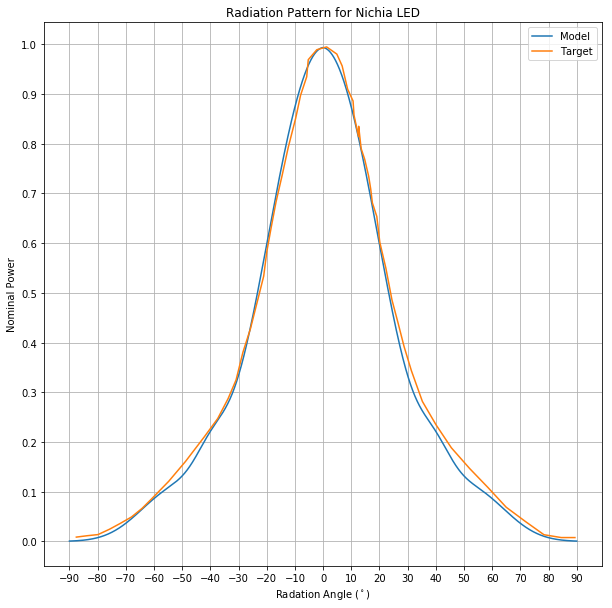

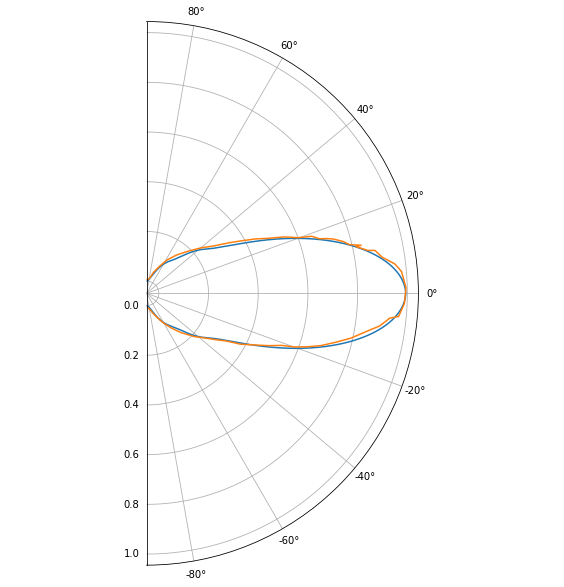

In [74]:
c1 , c2 ,c3 , c4 = model_param(Param)
ModelPrediction = I_calc_cosXY2(theta , 90 , c1 , c2 , c3 , c4)

print("Model Variables")
print("\t   c1 \t\t   c2 \t\t   c3 \t\t   c4")
for i in range(len(c1)) :
    print("%i. \t %1.3e \t %1.3e \t %1.3e \t %1.3e " % (i+1 , c1[i] , c2[i] , c3[i] , c4[i]))
    
plt.figure(figsize= (10,10))
plt.plot(angle , ModelPrediction , label = "Model")
plt.plot(x_axis , y_axis , label = "Target")
plt.xticks(np.arange(-90 , 100 , step = 10))
plt.yticks(np.arange(0,1.1 , step = 0.1))
plt.title("Radiation Pattern for %s LED" % datasheet[:-4])
plt.xlabel("Radation Angle $(^\circ)$")
plt.ylabel("Nominal Power")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize= (20 ,10 ))
plt.polar(theta , ModelPrediction)
plt.polar(x_axis_rad , y_axis)
plt.xlim(-np.pi/2 , np.pi/2)
plt.show()

		1st Contributor 		 2nd Contributor 		 3rd Contributor


Output()

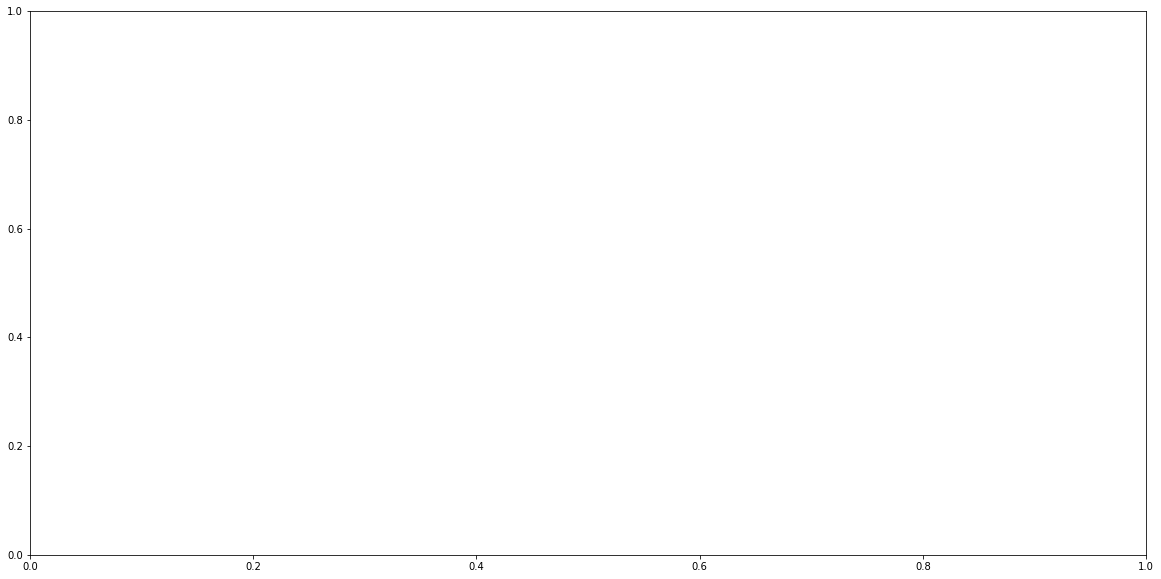

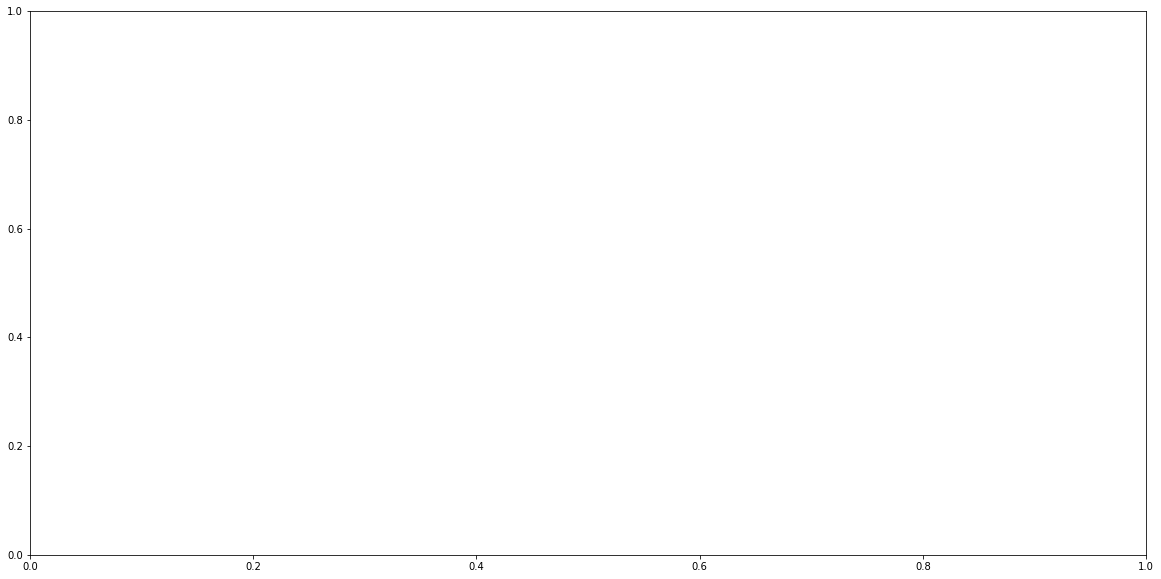

In [84]:
def f(c11 , c21 , c31 , c41 , c12 ,c22 , c32 , c42 , c13 , c23 ,c33 , c43) :
    file = csv.reader(open('Nichia.csv'))
    data = []
    x_axis = []
    y_axis = []

    for row in file:
        data.append([float(row[0]),float(row[1])])

    data.sort(key = lambda x: x[0])

    for item in data :
        x_axis.append(item[0])
        y_axis.append(item[1])
    angle = np.linspace(-90 , 90 , 181*10)
    theta = angle*np.pi/180
    Power1 = []
    Power2 = []
    Power3 = []
    Power = []

    Power1.append(I_calc_cosXY(theta, 90 , c11,c21,c31 , c41))
    Power2.append(I_calc_cosXY(theta, 90 , c12,c22,c32 , c42))
    Power3.append(I_calc_cosXY(theta, 90 , c13,c23,c33 , c43))

    for i in range(len(Power1)) :
        Power.append(Power1[i] + Power2[i] + Power3[i])

    plt.figure(figsize = (20,10))
    plt.plot(angle , Power  , label =  'Combined Model')
    plt.plot(angle , Power1 , label = '1st Contributor')
    plt.plot(angle , Power2 , label = '2nd Contributor')
    plt.plot(angle , Power3 , label = '3rd Contributor')
    plt.plot(x_axis , y_axis , label = 'Target')
    plt.grid()
    plt.legend()
    plt.title("Radiation Diagram Model")
    plt.xlabel("Radiation Angle (degrees)")
    plt.ylabel("PSD (W)")
    plt.xticks(np.arange(-90 , 100 , step = 10))
    plt.yticks(np.arange(0,max(Power)+.5 , step = 0.1))
    plt.show()
    
c11_s = widgets.FloatSlider(min = 0 , max =1  , step = 0.01, value = 1)
c21_s = widgets.IntSlider(  min = 0 , max =90 ,              value = 0)
c31_s = widgets.FloatSlider(min = 0 , max =30 , step = 0.1 , value = 3)
c41_s = widgets.FloatSlider(min = 0 , max =30 , step = 0.1 , value = 3)
c12_s = widgets.FloatSlider(min = 0 , max =1  , step = 0.1 , value = 0)
c22_s = widgets.IntSlider(  min = 0 , max =90 ,              value = 0)
c32_s = widgets.FloatSlider(min = 0 , max =30 , step = 0.1 , value = 0)
c42_s = widgets.FloatSlider(min = 0 , max =30 , step = 0.1 , value = 3)
c13_s = widgets.FloatSlider(min = 0 , max =1  , step = 0.1 , value = 0)
c23_s = widgets.IntSlider(  min = 0 , max =90 ,              value = 0)
c33_s = widgets.FloatSlider(min = 0 , max =35 , step = 0.1 , value = 0)
c43_s = widgets.FloatSlider(min = 0 , max =30 , step = 0.1 , value = 3)


print("\t\t1st Contributor \t\t 2nd Contributor \t\t 3rd Contributor")    
ip = interactive(f , c11 = c11_s , c21 = c21_s , c31 = c31_s , c41 = c41_s , c12 = c12_s , c22 = c22_s, c32 = c32_s , c42 = c42_s , c13 = c13_s , c23 = c23_s , c33 = c33_s , c43 = c43_s)
display(HBox([ip.children[0], ip.children[4] , ip.children[8] ]))#Show all controls
display(HBox([ip.children[1], ip.children[5] , ip.children[9] ]))#Show all controls
display(HBox([ip.children[2], ip.children[6] , ip.children[10] ]))#Show all controls
display(HBox([ip.children[3], ip.children[7] , ip.children[11] ]))#Show all controls
display(ip.children[-1])#Show the output